In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=f82f75db9bfbc60d0ad33881c161e7a48ed1e75ce20f187a475b60884633bdb4
  Stored in directory: /root/.cache/pip/wheels/8e/6b/70/59daa7c90a238610e34bac5916e001fe3d9bb0ec59c8cf5518
Successfully built rouge-score


In [3]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim':300,
          'embedding_dim':200}

In [7]:
from rouge_score import rouge_scorer

summary = pd.read_csv('/kaggle/input/InShortsdataset/news_summary.csv',encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/InShortsdataset/news_summary_more.csv',encoding='iso-8859-1')

raw = raw.rename(columns= {'headlines':'summary'})
summary = summary[['headlines','text']].rename(columns={'headlines':'summary'})

# concatenate the summary and raw files
df = pd.concat([raw,summary]).reset_index(drop=True)

summary.shape, raw.shape

((4514, 2), (98401, 2))

In [8]:
df.shape

(102915, 2)

In [9]:
raw.head()

,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


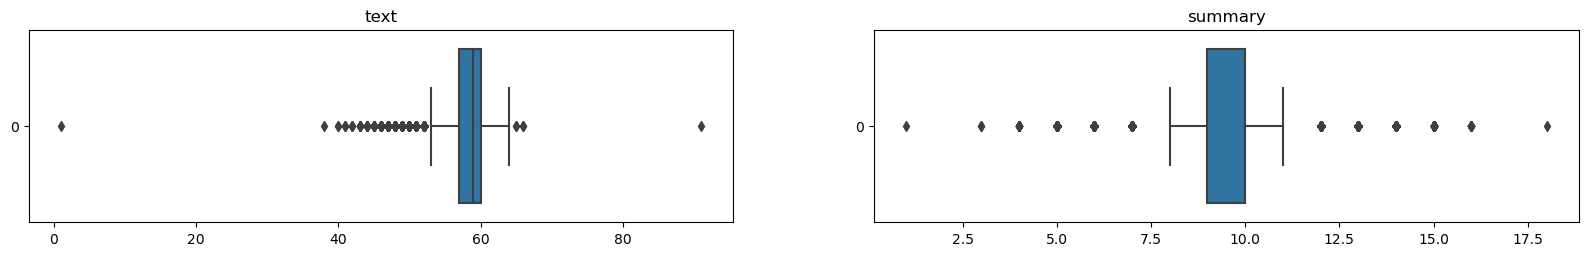

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(raw['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(raw['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [11]:
print(f'berore filtering: {raw.shape}')
pre = df.loc[(df['text'].str.split(" ").str.len()>config['min_text_len']) & (df['text'].str.split(" ").str.len()<config['max_text_len'])].reset_index(drop=True)
print(f'after filtering: {pre.shape}')

berore filtering: (98401, 2)
after filtering: (54572, 2)


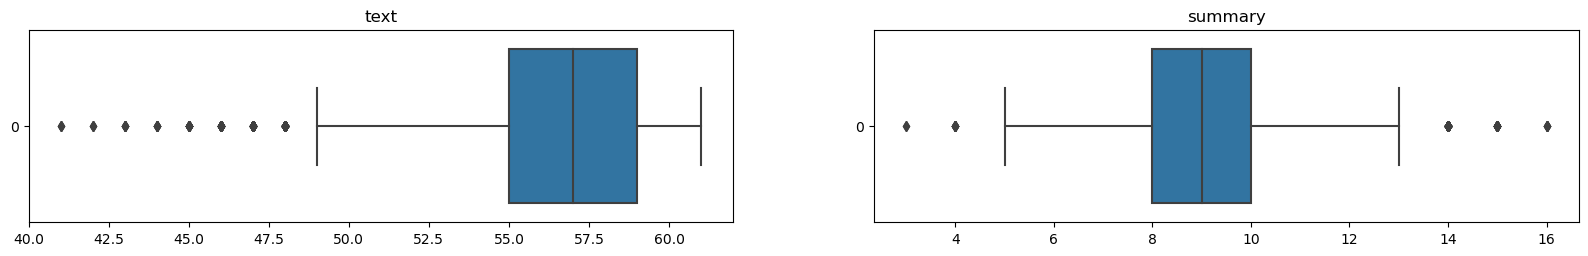

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(pre['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(pre['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [13]:
ind = 1
print(f'Text: {pre.text[ind]}')
print('')
print(f'Summary: {pre.summary[ind]}')
print('')
print(f'Text length: {len(pre.text[ind].split())}')
print(f'Summary length: {len(pre.summary[ind].split())}')

Text: India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.

Summary: India get all out for 92, their lowest ODI total in New Zealand

Text length: 56
Summary length: 13


In [14]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [15]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import re

# remove non-alphabetic character
def text_strip(sentence):

    sentence = re.sub("(\\t)"," ",str(sentence)).lower()
    sentence = re.sub("(\\r)"," ",str(sentence)).lower()
    sentence = re.sub("(\\n)"," ",str(sentence)).lower()

    # remove - if it occours more than one time
    sentence = re.sub("(--+)"," ",str(sentence)).lower()

    # remove . if it occours more than one time
    sentence = re.sub("(\.\.+)"," ",str(sentence)).lower()

    # remove special characters
    sentence = re.sub(r"[-<>()|&©⌀\[\]\'\",;?*!]"," ",str(sentence)).lower()

    # remove \x9* in text
    sentence = re.sub(r"(\\x9\d)"," ",str(sentence)).lower()

    # replace CH# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)","CM_NUM",str(sentence)).lower()

    # remove punctuations at the end of the word
    sentence = re.sub("(\.\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\-\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\:\s+)"," ",str(sentence)).lower()

    # remove multiple spaces
    sentence = re.sub("(\s+)"," ",str(sentence)).lower()

    return sentence

In [18]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '__START__' + text_strip(x) + '__END__')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre

,summary,text,cleaned_text,cleaned_summary
0,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan has deni...,sostok __START__rahat fateh ali khan denies ge...
1,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india recorded their lowest odi total in new z...,sostok __START__india get all out for 92 their...
2,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,andhra pradesh cm n chandrababu naidu has said...,sostok __START__called pm modi sir 10 times to...
3,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",isha ghosh an 81 year old member of bharat sco...,sostok __START__81 yr old woman conducts physi...
4,"Karan Johar, Tabu turn showstoppers on opening...",Filmmaker Karan Johar and actress Tabu turned ...,filmmaker karan johar and actress tabu turned ...,sostok __START__karan johar tabu turn showstop...
...,...,...,...,...
54567,Prosthetic fingers on sale to rig UP election:...,An investigation by India Today has unmasked a...,an investigation by india today has unmasked a...,sostok __START__prosthetic fingers on sale to ...
54568,"Kangana, Shahid, Saif starrer 'Rangoon' hits t...","The Kangana Ranaut, Shahid Kapoor and Saif Ali...",the kangana ranaut shahid kapoor and saif ali ...,sostok __START__kangana shahid saif starrer ra...
54569,Ticket collector bites off senior officer?s no...,A ticket collector on Thursday allegedly bit o...,a ticket collector on thursday allegedly bit o...,sostok __START__ticket collector bites off sen...
54570,Shouldn't rob their childhood: Aamir on kids r...,"Aamir Khan, while talking about reality shows ...",aamir khan while talking about reality shows o...,sostok __START__shouldn t rob their childhood ...


In [19]:
print(pre.shape)
post_pre = pre[((pre['cleaned_text'].str.split().str.len()<=config['max_text_len']) & (pre['summary'].str.split().str.len()<=(config['max_summary_len']+4)))].copy()
post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)
post_pre = post_pre.drop(['text','summary'],axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre

(54572, 4)
(39173, 4)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,sostok __START__rahat fateh ali khan denies ge...
1,andhra pradesh cm n chandrababu naidu has said...,sostok __START__called pm modi sir 10 times to...
2,filmmaker karan johar and actress tabu turned ...,sostok __START__karan johar tabu turn showstop...
3,days after he threatened to step down from his...,sostok __START__how long can i tolerate congre...
4,claiming there is a dearth of ideas among oppo...,sostok __START__i think the opposition even dr...
...,...,...
39168,shiv sena s tally in recently concluded bmc el...,sostok __START__bmc polls shiv sena s tally ri...
39169,a new poster of the upcoming epic historical f...,sostok __START__new poster of baahubali 2 feat...
39170,indian captain virat kohli on friday got out w...,sostok __START__virat kohli out for a duck for...
39171,an investigation by india today has unmasked a...,sostok __START__prosthetic fingers on sale to ...


In [20]:
np.array(post_pre['text'])

array(['pakistani singer rahat fateh ali khan has denied receiving any notice from the enforcement directorate over allegedly smuggling foreign currency out of india it would have been better if the authorities would have served the notice first if any and then publicised this reads a press release issued on behalf of rahat the statement further called the allegation bizarre .',
       'andhra pradesh cm n chandrababu naidu has said when i met then us president bill clinton i addressed him as mr clinton not as sir pm narendra modi is my junior in politics i addressed him as sir 10 times i did this to satisfy his ego in the hope that he will do justice to the state he added.',
       'filmmaker karan johar and actress tabu turned showstoppers for gaurav gupta on the opening night of lakmã\x83â fashion week summer/ resort 2019 while johar wore a red sequinned jacket with black pants tabu walked the ramp in a grey embellished gown the fashion show which began on january 29 will continue t

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre['text']),
                                                      np.array(post_pre['summary']),
                                                      test_size = 0.1,
                                                      shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((35255,), (3918,), (35255,), (3918,))

In [22]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(list(x_train))
#text_tokenizer.word_counts

In [23]:
def get_rare_words(text_col):

    # prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))

    thresh = 5
    cnt = 0
    total_count = 0

    for key, value in text_tokenizer.word_counts.items():
        total_count = total_count + 1
        if value < thresh:
            cnt = cnt + 1
    
    print('% of rare words in vocabulary:',(cnt/total_count)*100)

    return cnt, total_count

In [24]:
x_train_cnt, x_train_total_count = get_rare_words(x_train)

% of rare words in vocabulary: 64.53556923883139


In [25]:
x_tokenizer = Tokenizer(num_words = x_train_total_count-x_train_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequence to integer sequence
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen = config['max_text_len'],padding='post')
x_val = pad_sequences(x_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
x_voc = x_tokenizer.num_words +1

print('vocabulary size: ',x_voc)

vocabulary size:  18950


In [26]:
y_train_cnt, y_train_total_cnt = get_rare_words(y_train)

% of rare words in vocabulary: 67.41521539871678


In [27]:
y_tokenizer = Tokenizer(num_words = y_train_total_cnt-y_train_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequence to integer sequence
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

# pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = config['max_text_len'],padding='post')
y_val = pad_sequences(y_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
y_voc = y_tokenizer.num_words +1

print('vocabulary size: ',y_voc)

vocabulary size:  7822


In [28]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output1,state_h,state_c) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output2,state_h,state_c) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs,state_h,state_c) = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc,embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM 
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state)= decoder_lstm(dec_emb,initial_state=[state_h,state_c])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_inputs, decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 200)      3790000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [29]:
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

model_name = './model.h5'

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
# Eralystopping
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [30]:
history = model.fit(
    [x_tr,y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)[:, 1:],
    epochs =500,
    callbacks = [es, save_model],
    batch_size = 512,
    validation_data = ([x_val,y_val[:, :-1]],
                       y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:, 1:])
                    )

Epoch 1/500
69/69 [==============================] - ETA: 0s - loss: 2.5187 - accuracy: 0.7929
Epoch 1: val_loss improved from inf to 1.30645, saving model to ./model.h5
69/69 [==============================] - 151s 2s/step - loss: 2.5187 - accuracy: 0.7929 - val_loss: 1.3065 - val_accuracy: 0.8176
Epoch 2/500
69/69 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.8158
Epoch 2: val_loss improved from 1.30645 to 1.25794, saving model to ./model.h5
69/69 [==============================] - 126s 2s/step - loss: 1.3556 - accuracy: 0.8158 - val_loss: 1.2579 - val_accuracy: 0.8309
Epoch 3/500
69/69 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.8442
Epoch 3: val_loss improved from 1.25794 to 1.15970, saving model to ./model.h5
69/69 [==============================] - 122s 2s/step - loss: 1.2140 - accuracy: 0.8442 - val_loss: 1.1597 - val_accuracy: 0.8537
Epoch 4/500
69/69 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.85

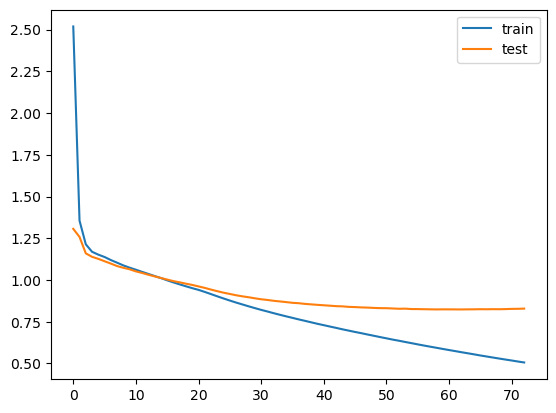

In [31]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

In [32]:
model.load_weights('./model.h5')

In [33]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index 

In [46]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [52]:
from tqdm import tqdm
actual = []
predicted = []
for i in tqdm(range(0,50)):
    print('Review:', seq2text(x_tr[i]))

    actual.append(seq2summary(y_tr[i]))
    print('Original Summary', actual[-1])

    predicted.append(decode_sequence(x_tr[i].reshape(1,config['max_text_len'])))
    print('Prdicted Summary', predicted[-1])
    print()

prediction_df = pd.DataFrame({'Actual':actual,'Predicted':predicted})
prediction_df.head(10)

  0%|          | 0/50 [00:00<?, ?it/s]

Review: saudi arabia will build churches for christian worshippers for the first time in the country s history according to reports the kingdom has signed a deal regarding the same with the vatican the landmark decision is reportedly aimed at advocating amid efforts by saudi arabia to modernise the conservative kingdom 
Original Summary start saudi to build churches in country for the 1st time report end 
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 1/50 [00:00<00:38,  1.26it/s]

Prdicted Summary  start saudi arabia to host first female university end

Review: pakistan s president mamnoon hussain on saturday conferred the country s highest civilian honour e imtiaz on army chief qamar bajwa and chairman joint chiefs of staff committee hayat in recognition of their services the award is given to civilians based on their achievements towards world recognition for pakistan or outstanding service for the country 
Original Summary start pakistan awards e imtiaz to top military leaders end 
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 2/50 [00:01<00:40,  1.20it/s]

Prdicted Summary  start pak declares emergency for 1st time in pakistan end

Review: in a move to avert the threat of islamic state terror group in pakistan the government has decided to collect data on its citizens who are suspected of waging jihad abroad reportedly around 100 pakistanis have travelled to syria and iraq to join the islamic state since the rise of the terror group in the middle east 
Original Summary start pak collecting data on citizens suspected of jihad end 
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 3/50 [00:02<00:44,  1.06it/s]

Prdicted Summary  start pak court allows to pay ã¢ââ¹20l to be held in syria end

Review: the home ministry has reportedly returned a bill moved by the delhi government for a salary hike up to 400 for its mlas the ministry has sought more clarifications regarding the provisions included in the bill as per reports the mha has said that the burden on exchequer would not to the revenues of the delhi government 
Original Summary start mha returns bill on 400 salary hike for delhi mlas report end 
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 4/50 [00:03<00:44,  1.03it/s]

Prdicted Summary  start centre approves ã¢ââ¹1 lakh crore to protest against delhi govt end

Review: the zoo in canadian province has shifted its penguins inside because of the cold temperature the zoo annually shifts its penguins indoors when temperatures fall below celsius zoo curator said these are not wild birds adding we just don t want to expose them to too much 
Original Summary start canadian zoo due to cold end 
1/1 [==============================] - 0s 26ms/step


 10%|█         | 5/50 [00:04<00:41,  1.09it/s]

Prdicted Summary  start mumbai airport to get its own museum end

Review: russia on thursday warned that the country would retaliate if us authorities took action against its media outlets rt and russia is dedicated to all international and norms regarding the freedom of speech and proved that on many occasions officials said earlier us authorities demanded that russian state controlled broadcaster rt be registered as a foreign agent 
Original Summary start russia warns us over treatment of its media outlets end 
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 6/50 [00:05<00:42,  1.05it/s]

Prdicted Summary  start russia warns us against russia over its diplomats end

Review: mumbai indians defeated delhi daredevils by 14 runs on saturday in a low scoring encounter at the wankhede stadium mitchell mcclenaghan took 3 wickets for mumbai as delhi managed to score only 128 7 while chasing down the target of 143 with their sixth win in seven matches mumbai remained on top of the points table of ipl 2017 
Original Summary start mumbai remain on top of ipl points table with win over delhi end 
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 7/50 [00:06<00:42,  1.00it/s]

Prdicted Summary  start mumbai indians sets record for most int l cricket in ipl end

Review: a man in faridabad was forced to carry the dead body of his granddaughter on his shoulder after allegedly being denied an ambulance by a government hospital the family of the deceased has also claimed that the doctors did not give her adequate attention due to which she lost her life 
Original Summary start man carries dead granddaughter after being denied ambulance end 
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 8/50 [00:07<00:40,  1.05it/s]

Prdicted Summary  start man carries dead granddaughter after being denied ambulance end

Review: us based startup has developed a chair that it claims uses body s natural ability to strengthen the core and intensify burn the chair features an adjustable air which makes the chair require constant balance claims that when a person places feet on the platform and balance their centre of gravity they experience real exercise 
Original Summary start us startup claims its chair can help burn end 
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 9/50 [00:08<00:38,  1.06it/s]

Prdicted Summary  start startup that can be used by its own aircraft end

Review: microsoft has said it ll work with richard who became a social media sensation after posting pictures of himself ms word on a to provide device and software support who is a teacher in ghana revealed he had no working computer to teach the children he was also invited by microsoft at its education exchange 
Original Summary start microsoft offers support to man who ms word on board end 
1/1 [==============================] - 0s 23ms/step


 20%|██        | 10/50 [00:09<00:39,  1.01it/s]

Prdicted Summary  start tesla is a lot of the of the of the of end

Review: technology giant apple has started selling worth ã¢ââ¹2 300 that lets users charge their iphones and use their headsets simultaneously the features a 3 jack and a lightning port and works with the newly launched iphone x iphone 8 plus iphone 8 models the which is manufactured by requires ios 10 or later to work 
Original Summary start lets users charge iphone use end 
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 11/50 [00:10<00:36,  1.08it/s]

Prdicted Summary  start apple launches feature that inspired by iphones end

Review: australia has become the first country in the world to recognise orphanage trafficking as a form of modern slavery children from smaller countries are recruited in in the west for the purpose of profit through foreign aid as per estimates 80 of children living in the world s have at least one living parent 
Original Summary start australia 1st to recognise orphanage trafficking as slavery end 
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 12/50 [00:11<00:36,  1.03it/s]

Prdicted Summary  start australia to host 1st ever at the world s largest end

Review: the bengaluru police arrested two men for allegedly taking pictures of four women without their permission at a city mall earlier this week the women confronted the men and snatched the mobile phone of one of the accused before deleting the pictures police said the women also accused the two men of using foul language during the confrontation 
Original Summary start two men arrested for taking pictures of women in b luru mall end 
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 13/50 [00:12<00:34,  1.07it/s]

Prdicted Summary  start 2 women arrested for molesting woman in delhi end

Review: speaking at the india today conclave 2017 president pranab mukherjee said four of the five years during the upa i the growth rate was more than 8 percent the base of indian economy was so strong that it sustained 2008 global economic crisis mukherjee also praised pm narendra modi saying he has acquired over external affairs 
Original Summary start congress led upa made economy strong president mukherjee end 
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 14/50 [00:13<00:35,  1.01it/s]

Prdicted Summary  start india is the most of pm modi on 1st time in india end

Review: the bharatiya janata party bjp came to power in 2014 to fight against corruption party leader subramanian swamy said maintaining pm narendra modi s reputation as a man of governance and people to rise above caste and choose a party which will safeguard their interest were also the reasons why the party came into power he added 
Original Summary start bjp came into power in 2014 to fight corruption swamy end 
1/1 [==============================] - 0s 22ms/step


 30%|███       | 15/50 [00:14<00:34,  1.01it/s]

Prdicted Summary  start bjp s party is a political party says bjp leader end

Review: youtube has updated its creator guidelines that ban dangerous challenges and dares like the bird box challenge youtube added it prohibits challenges presenting a risk of serious danger or death and content causing children to experience severe emotional distress recently a 17 year old us girl driving crashed into another vehicle while doing the bird box challenge 
Original Summary start youtube bans dangerous challenges dares like bird box end 
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 16/50 [00:15<00:32,  1.05it/s]

Prdicted Summary  start youtube bans use of human on human rights end

Review: actress emma watson wore a yellow gown inspired by the ball gown worn by disney character to an event in new york the gown which was designed by fashion house christian dior has been made of sustainable eco age fabric emma will be seen portraying in the upcoming film beauty and the beast 
Original Summary start emma watson wears inspired yellow gown to event end 
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 17/50 [00:16<00:30,  1.07it/s]

Prdicted Summary  start fans at cannes match at madame tussauds end

Review: thai authorities on monday arrested a group of 10 russians who were allegedly running a sexual training class in the town of officials said that the group ran the class for more than 40 russian men and women at a hotel they will be charged with working in thailand without permission and not for conducting the course 
Original Summary start thailand arrests 10 russians for running sex training class end 
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 18/50 [00:17<00:29,  1.07it/s]

Prdicted Summary  start thailand arrests for 10 yrs after being jailed for end

Review: tata group may have to pay 1 3 billion to the government in dues to get approval for its mobile business sale to bharti airtel according to reports the department of telecommunications is demanding that tata teleservices must clear any obligations to the government before it approves the deal sunil bharti mittal led airtel is unlikely to pay the sum 
Original Summary start tata might pay 1 3 bn to govt for mobile biz sale to airtel end 
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 19/50 [00:18<00:29,  1.05it/s]

Prdicted Summary  start tata steel to pay cr to settle lawsuit against rcom end

Review: a youth has been arrested in maharashtra for allegedly killing his ex girlfriend on her 19th birthday after taking her to a secluded place on wednesday police said the accused took her to a secluded spot on the pretext of cutting her birthday cake in private following which he assaulted and strangled her with a piece of cloth 
Original Summary start ex lover takes girl to area kills her on b day end 
1/1 [==============================] - 0s 24ms/step


 40%|████      | 20/50 [00:19<00:28,  1.05it/s]

Prdicted Summary  start delhi man beaten up for misbehaving with his father end

Review: the delhi high court on tuesday questioned delhi police over the delay in finding reasons behind the death of congress mp shashi tharoor s wife sunanda pushkar here is somebody who passed away back in 2014 and you police initially said it was a suicide but later it turned out to be a homicide the bench said 
Original Summary start hc questions police over delay in probing s death end 
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 21/50 [00:19<00:27,  1.05it/s]

Prdicted Summary  start delhi police chief s daughter s daughter arrested for end

Review: a doctor registered with delhi medical council has been barred from all exams held by the national board of examination for seven years after he was allegedly caught impersonating other candidates in medical tests the accused used to write papers of candidates of different medical examinations under different names and charge them huge amounts of money officials said 
Original Summary start doctor writes exam for medical students barred for 7 years end 
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 22/50 [00:20<00:27,  1.03it/s]

Prdicted Summary  start students protest against students for medical students in end

Review: indo canadian youtube star lilly singh also known as superwoman said if you watch something and it makes you laugh great if it doesn t that comedy isn t wrong it s just not suitable for you calling comedy very lilly added the best thing you can do is promote what you love and not bash what you hate 
Original Summary start if it doesn t make you laugh that comedy isn t wrong end 
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 23/50 [00:22<00:29,  1.08s/it]

Prdicted Summary  start i can t make a lot of the of the world s tweets user end

Review: taxi drivers have a lifestyle that requires them to stay awake and or work long hours which leads to some of them picking up the habit of chewing tobacco to protect the smiles of the people who drive mumbai organised a free dental check up camp at mumbai international airport availed during their waiting time to identify their problems 
Original Summary start hosts free camp for taxi drivers in mumbai end 
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 24/50 [00:23<00:25,  1.03it/s]

Prdicted Summary  start bengaluru airport offers free for free end

Review: engineers have developed a new cooling technology that uses jumping droplets to cool processors and power electronics when placed beneath electronics the droplets after the electronics heat escaping towards cooling structures on the floor the floor made of a material the merging droplets making them jump away to the top for 
Original Summary start new tech to cool electronics using jumping made end 
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 25/50 [00:24<00:24,  1.01it/s]

Prdicted Summary  start mit team develops device to detect cancer end

Review: the taliban militant group has seized a district in afghanistan s province officials said government forces lost the region after failing to get adequate supplies or in their fight against the militant group the taliban claimed to have killed 15 members of the security forces and wounded 14 others in the offensive 
Original Summary start taliban seizes district in northern afghanistan end 
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 26/50 [00:24<00:22,  1.06it/s]

Prdicted Summary  start afghan taliban kills 2 civilians in afghanistan end

Review: the goa unit of shiv sena has opposed electronic dance music festivals in the state saying such events are used by drug peddlers to make money not allowing festival this year would be the first step to clean the tourism from drug menace sena s goa spokesperson said goa had been home to and supersonic 
Original Summary start drug make money in goa shiv sena end 
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 27/50 [00:25<00:22,  1.02it/s]

Prdicted Summary  start bjp leader s name to be renamed as prez kovind end

Review: after banning certain types of plastic bags the maharashtra government is now planning to ban plastic banners containers and hoardings among others by march 2018 however plastic used for and packaging will be exempted from the ban officials said the state environment department has directed the authorities to ensure strict implementation of the proposed ban 
Original Summary start maharashtra may ban plastic end 
1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 28/50 [00:26<00:21,  1.02it/s]

Prdicted Summary  start govt to install plastic ban on trains end

Review: censor board chief pahlaj nihalani has confirmed that the censor board will go digital now producers would not have to submit of their films to the cbfc everything including their films will be submitted for certification online said nihalani he added we re just waiting for the green signal from the information and broadcasting ministry 
Original Summary start censor board to go digital confirms chief pahlaj nihalani end 
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 29/50 [00:28<00:21,  1.03s/it]

Prdicted Summary  start cbfc chief pahlaj to not to be a certificate remake reports end

Review: attacking us president donald trump over revelations made in fire and fury inside the trump white house north korea said the popularity of the book points to the us leader s political demise adding that trump was being humiliated worldwide the reclusive nation said that the book s sales reflected rapidly surging anti trump sentiments in the international community 
Original Summary start fire and sales predict trump s end north korea end 
1/1 [==============================] - 0s 33ms/step


 60%|██████    | 30/50 [00:29<00:22,  1.14s/it]

Prdicted Summary  start us prez trump s korea s replacement could be a end

Review: technology major google on wednesday launched its digital assistant called google assistant for iphones google assistant on ios will be able to carry out actions like sending and playing songs but will not let users perform actions like setting notably google assistant has been pegged as direct competition for apple s own digital assistant siri 
Original Summary start google launches its digital assistant for iphones end 
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 31/50 [00:30<00:21,  1.15s/it]

Prdicted Summary  start google adds feature to let users from google play store end

Review: the state bank of india sbi has announced that cheque books of six banks that merged with it in april this year would become invalid from september 30 sbi has asked customers to submit applications for getting replacements of their cheque books further sbi said codes of these banks will become invalid from september 30 
Original Summary start cheque books of six banks that merged with sbi to be invalid end 
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 32/50 [00:31<00:20,  1.13s/it]

Prdicted Summary  start sbi files insolvency case against rcom for its first time end

Review: danish inventor peter has been sentenced to life in prison without parole after he was found guilty of murdering swedish journalist kim wall on his submarine wall had visited onboard his submarine to conduct an interview in august last year her remains were found at sea 11 days later 
Original Summary start danish inventor jailed for life over swedish journo s murder end 
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 33/50 [00:32<00:18,  1.09s/it]

Prdicted Summary  start uk journalist jailed for killing of sex abuse scandal end

Review: a thief robbed a jewellery store in bengaluru by drilling a hole in its ceiling from a lodge room located above it he was nabbed within 12 hours of the theft after a bus driver identified him and alerted the police of his whereabouts over 10 kg of gold and silver articles were recovered from him 
Original Summary start thief who ceiling to rob jewellery store end 
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 34/50 [00:33<00:16,  1.02s/it]

Prdicted Summary  start man steals in delhi after 9 months end

Review: actress kriti sanon s instagram account was hacked on monday kriti took to twitter to ask her fans not to respond to any messages from her instagram account hacker reportedly posted old pictures of the actress and asked users to follow a new account later she managed to recover and restore her account 
Original Summary start kriti sanon s instagram account hacked end 
1/1 [==============================] - 0s 25ms/step


 70%|███████   | 35/50 [00:34<00:15,  1.01s/it]

Prdicted Summary  start kriti sanon to kylie s instagram pic with her end

Review: developing startup has raised an undisclosed amount in seed funding from matrix partners india the startup s co founder said the funding will be used for marketing and for hiring in functions such as engineering accounting sales and advertising currently has three chatbots and which run using instant messaging apps 
Original Summary start maker gets funding from partners india end 
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 36/50 [00:35<00:13,  1.02it/s]

Prdicted Summary  start startup raises 1 mn in series a mn end

Review: the color institute has announced a new shade of purple in the honour of american singer actor prince who passed away in 2016 at the age of 57 the new has been named love symbol 2 notably the singer had a custom made purple piano and was seen wearing purple clothes at concerts 
Original Summary start announces new as a tribute to prince end 
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 37/50 [00:36<00:12,  1.03it/s]

Prdicted Summary  start s named s new year s youngest person end

Review: alia bhatt while talking about working with varun dhawan in the upcoming film kalank said though he is fabulous he is troubling me as always varun and i are working very hard on set she added kalank will be alia and varun s fourth film together after student of the year sharma ki dulhania and badrinath ki dulhania 
Original Summary start varun is always me on sets of alia bhatt end 
1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 38/50 [00:37<00:12,  1.05s/it]

Prdicted Summary  start i am not a big b day with my life alia bhatt end

Review: congress leader kapil sibal said that gst was to simple and not a and simple as described by the pm he further stressed that the new tax regime was good for the government and bad for the common man sibal claimed multilateral gst was for the rich by the rich and of the 
Original Summary start gst is to simple tax says kapil sibal end 
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 39/50 [00:38<00:11,  1.05s/it]

Prdicted Summary  start gst is a political economy pm modi on demonetisation end

Review: chinese foreign ministry on wednesday said that its troops are always committed to maintain peace and along the indo china border we always patrol along the chinese side of line of control chinese officials said this comes after reports that indian border guards foiled an attempt by chinese soldiers to enter indian territory in ladakh on tuesday 
Original Summary start china says troops committed to maintain peace along border end 
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 40/50 [00:39<00:10,  1.01s/it]

Prdicted Summary  start india china hold joint military cooperation with un end

Review: ahead of dussehra rjd has put up a poster outside its party office in bihar s patna showing party supremo lalu prasad yadav s son tejashwi as lord ram and bihar cm nitish kumar as tejashwi can be seen pointing an arrow at kumar with the poster s caption reading whenever commits atrocities a ram is born 
Original Summary start rjd poster shows bihar cm as and tejashwi as lord ram end 
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 41/50 [00:40<00:09,  1.04s/it]

Prdicted Summary  start rjd poster of ram rahim s son taimur emerges online end

Review: wanted indian mujahideen terrorist khan on wednesday was arrested by the special cell of the delhi police khan was wanted for his involvement in five bomb blast cases and has been on the run since the september 2008 house encounter the national investigation agency nia had declared a reward of ã¢ââ¹10 lakh for information about him 
Original Summary start wanted indian mujahideen terrorist arrested by delhi police end 
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 42/50 [00:41<00:08,  1.05s/it]

Prdicted Summary  start hafiz saeed s daughter arrested for his house in pakistan end

Review: the death toll in the terrorist attack in barcelona s city centre has risen to 13 the spanish government said police officials said that they have activated attack protocols adding that the motive behind the attack was not yet clear people have been urged to stay away from the area and emergency services have requested closure of local metro stations 
Original Summary start death toll in spain terror attack rises to 13 end 
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 43/50 [00:42<00:06,  1.01it/s]

Prdicted Summary  start death toll in china rises to italy end

Review: at least 14 people were killed and 12 others were injured on monday in nigeria as gunmen opened fire indiscriminately at people returning from new year s eve service from a church according to reports authorities have blamed the incident on the fight for supremacy among rival cult groups in the area and have launched a manhunt for the attackers 
Original Summary start gunmen kill 14 people leaving church in nigeria end 
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 44/50 [00:43<00:05,  1.01it/s]

Prdicted Summary  start 3 killed 40 injured in knife attack in us end

Review: instagram founders mike and kevin systrom had refused to copy snapchat s stories feature until facebook ceo mark zuckerberg personally asked for it a report has claimed zuckerberg was concerned that instagram missing out on an entire generation without stories however a company spokesperson said instagram was not into adding stories and was created internally 
Original Summary start zuckerberg asked instagram to copy snapchat feature report end 
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 45/50 [00:44<00:04,  1.07it/s]

Prdicted Summary  start instagram account hacked to delete snapchat end

Review: delhi lieutenant governor anil baijal on wednesday suspended two public works department pwd engineers after a sanitation worker died while cleaning a hospital s sewer recently zero tolerance for negligence in such cases he tweeted notably the delhi government has also banned manual cleaning of after 10 workers died in over a month while cleaning sewer lines 
Original Summary start delhi lt governor suspends 2 pwd engineers over sewer death end 
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 46/50 [00:45<00:03,  1.05it/s]

Prdicted Summary  start delhi hc orders sealing of liquor shops in delhi end

Review: indian cricket team s head coach ravi shastri visited the temple in thiruvananthapuram on monday ahead of the third and final t20i against new zealand shastri who offered a coconut to the had reportedly visited the temple with his mother when he was four years old the t20i series against new zealand is currently tied 1 1 
Original Summary start shastri visits temple ahead of 3rd t20i end 
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 47/50 [00:46<00:02,  1.01it/s]

Prdicted Summary  start sachin visits his 100th century in india s 1st time end

Review: london headquartered startup which provides a financial exchange platform for blockchain based digital assets has raised over 24 million is also launching its cryptocurrency digital asset exchange token with sale from february 10 the startup provides tools for exchange clearing settlement registry and brokerage 
Original Summary start blockchain firm raises 24 mn to launch own cryptocurrency end 
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 48/50 [00:47<00:01,  1.10it/s]

Prdicted Summary  start buys blockchain management startup for end

Review: about 45 of indians have paid a bribe to get their work done in the past year according to a report by citizen engagement platform of the people who had paid a bribe 84 have made the payment for the resolution of local issues including municipal and police concerns local tax compliance and property registration the report added 
Original Summary start 45 indians have paid a bribe in the past year report end 
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 49/50 [00:48<00:00,  1.04it/s]

Prdicted Summary  start us court rules out of most popular of the year end

Review: patidar leader hardik patel was booked on friday for allegedly delivering a political speech at an educational and farmers welfare event in gujarat s jamnagar in november 2017 in the fir jamnagar sub divisional magistrate rk patel alleged that hardik had violated the conditions laid down for organising the event by politicising an educational program 
Original Summary start hardik booked for political speech at farmers event end 
1/1 [==============================] - 0s 25ms/step


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

Prdicted Summary  start karunanidhi s son held for karunanidhi s residence end



,Actual,Predicted
0,start saudi to build churches in country for t...,start saudi arabia to host first female unive...
1,start pakistan awards e imtiaz to top military...,start pak declares emergency for 1st time in ...
2,start pak collecting data on citizens suspecte...,start pak court allows to pay ã¢ââ¹20l to be...
3,start mha returns bill on 400 salary hike for ...,start centre approves ã¢ââ¹1 lakh crore to p...
4,start canadian zoo due to cold end,start mumbai airport to get its own museum end
5,start russia warns us over treatment of its me...,start russia warns us against russia over its...
6,start mumbai remain on top of ipl points table...,start mumbai indians sets record for most int...
7,start man carries dead granddaughter after bei...,start man carries dead granddaughter after be...
8,start us startup claims its chair can help bur...,start startup that can be used by its own air...
9,start microsoft offers support to man who ms w...,start tesla is a lot of the of the of the of end


In [58]:
r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rougeL','rougeL'],use_stemmer=True)

for index, data in prediction_df.iterrows():
    r_score = scorer.score(data.Actual, data.Predicted)
    pr = list(r_score['rougeL'])[0]
    rc = list(r_score['rougeL'])[1]
    f_meas = list(r_score['rougeL'])[2]

    rouge_pr.append(pr)
    rouge_rc.append(rc)
    rouge_f.append(f_meas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f
prediction_df.head(10)

,Actual,Predicted,rouge_pr,rouge_rc,rouge_f
0,start saudi to build churches in country for t...,start saudi arabia to host first female unive...,0.444444,0.307692,0.363636
1,start pakistan awards e imtiaz to top military...,start pak declares emergency for 1st time in ...,0.300000,0.300000,0.300000
2,start pak collecting data on citizens suspecte...,start pak court allows to pay ã¢ââ¹20l to be...,0.230769,0.300000,0.260870
3,start mha returns bill on 400 salary hike for ...,start centre approves ã¢ââ¹1 lakh crore to p...,0.250000,0.230769,0.240000
4,start canadian zoo due to cold end,start mumbai airport to get its own museum end,0.333333,0.428571,0.375000
5,start russia warns us over treatment of its me...,start russia warns us against russia over its...,0.700000,0.636364,0.666667
6,start mumbai remain on top of ipl points table...,start mumbai indians sets record for most int...,0.307692,0.285714,0.296296
7,start man carries dead granddaughter after bei...,start man carries dead granddaughter after be...,1.000000,1.000000,1.000000
8,start us startup claims its chair can help bur...,start startup that can be used by its own air...,0.363636,0.400000,0.380952
9,start microsoft offers support to man who ms w...,start tesla is a lot of the of the of the of end,0.153846,0.166667,0.160000
